In [30]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
import numpy as np
import pandas as pd
from IPython.display import display
from Custom_kernel import *

import sys
sys.path.append('../Data')

In [3]:
# Load Data

X = pd.read_csv('../Data/[Benz] X.csv')
X_lexi = pd.read_csv('../Data/[Benz] X_lexi.csv')
X_lexi_nd = pd.read_csv('../Data/[Benz] X_lexi_nd.csv')
X_sorted = pd.read_csv('../Data/[Benz] X_sorted.csv')
X_concat = pd.read_csv('../Data/[Benz] X_concat.csv')
X_coulomb = pd.read_csv('../Data/[Benz] X_coulomb.csv')

y_energy = pd.read_csv("../Data/[Benz] y_energy.csv")
y_elec = pd.read_csv("../Data/[Benz] y_elec.csv")
y_delta_energy = pd.read_csv("../Data/[Benz] y_delta_energy.csv")
y_delta_elec = pd.read_csv("../Data/[Benz] y_delta_elec.csv")

In [4]:
def evaluate_performance(model, X, y, num_training_sample, num_trials):

    """ 
    Given the number of training samples used, 
    calculate the average and standard deviation of MSE across a certain number of trials.
    For each trial, a specified number of training examples is used to train the model, 
    which is then evaluated on the rest of the data set.

    Args:
        X (ndarray): training data; size (N, m) where N is the number of training examples and m is the number of features
        y (ndarray): target data; size (N, 1)
        num_training_sample (int): the number of samples used for training
        num_trials: the number of trials 
    
    Returns:
        average_error: the average MSE across all trials
        std_dev_error: standard deviation of the error across all trials
    """

    errors = []
    test_size = 1.0 - num_training_sample/X.shape[0]

    for i in range(num_trials):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=i)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        error = mean_absolute_error(y_val, y_pred) 
        errors.append(error)
    
    average_error = np.mean(errors)
    std_dev_error = np.std(errors)/np.sqrt(num_trials)
    return average_error, std_dev_error

In [5]:
def evaluate_performance_custom_kernel(model, X, y, num_training_sample, num_trials, similarity_kernel, params):
    """ 
    Given the number of training samples used, 
    calculate the average and standard deviation of MSE across a certain number of trials.
    For each trial, a specified number of training examples is used to train the model, 
    which is then evaluated on the rest of the data set.

    Args:
        X (ndarray): training data; size (N, m) where N is the number of training examples and m is the number of features
        y (ndarray): target data; size (N, 1)
        num_training_sample (int): the number of samples used for training
        num_trials: the number of trials 
        similarity_kernel: the custom kernel used
    
    Returns:
        average_error: the average MSE across all trials
        std_dev_error: standard deviation of the error across all trials
    """

    errors = []
    test_size = 1.0 - num_training_sample/X.shape[0]

    for i in range(num_trials):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=42+i)
        X_train = X_train.to_numpy()
        y_train = y_train.to_numpy()
        X_val = X_val.to_numpy()
        y_val = y_val.to_numpy()

        similarity_matrix = create_similarity_matrix(X_train, X_train, similarity_kernel, params)
        model.fit(similarity_matrix, y_train)
        prediction_matrix = create_similarity_matrix(X_train, X_val, similarity_kernel, params)
        y_pred = model.predict(prediction_matrix)
        error = mean_absolute_error(y_val, y_pred) 
        errors.append(error)
    
    average_error = np.mean(errors)
    std_dev_error = np.std(errors)/np.sqrt(num_trials)
    return average_error, std_dev_error

## Ordinary Gaussian Kernel ##

### Vanilla ###

In [16]:
# model_gaussian

best_params = {'alpha': 1e-17, 'gamma': 2e-07, 'kernel': 'rbf'}
model_gaussian = KernelRidge(**best_params)

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_gaussian = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance(model_gaussian, X, y_delta_energy, num_training_sample, num_trials)
        model_performance_gaussian.at[index, 'training size'] = num_training_sample
        model_performance_gaussian.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_gaussian.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_gaussian)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,2030.039751,136.552925
2,4,2534.616037,296.4471
3,8,1906.887166,146.451174
4,16,806.12498,161.388228


In [17]:
# model_gaussian

best_params = {'alpha': 1e-17, 'gamma': 2e-07, 'kernel': 'rbf'}
model_gaussian_elec = KernelRidge(**best_params)

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_gaussian_elec = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance(model_gaussian_elec, X, y_delta_elec, num_training_sample, num_trials)
        model_performance_gaussian_elec.at[index, 'training size'] = num_training_sample
        model_performance_gaussian_elec.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_gaussian_elec.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_gaussian_elec)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,1969.794441,121.067344
2,4,2426.320507,278.52687
3,8,1846.13098,141.497672
4,16,828.452462,157.30972


### Lexi Representation ###

In [13]:
# model_gaussian_lexi

best_params = {'alpha': 1e-17, 'gamma': 2e-07, 'kernel': 'rbf'}
model_gaussian_lexi = KernelRidge(**best_params)

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_gaussian_lexi = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance(model_gaussian_lexi, X_lexi, y_delta_energy, num_training_sample, num_trials)
        model_performance_gaussian_lexi.at[index, 'training size'] = num_training_sample
        model_performance_gaussian_lexi.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_gaussian_lexi.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_gaussian_lexi)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,2070.368525,133.672151
2,4,3015.499012,315.183767
3,8,2228.600276,247.674129
4,16,255.634073,158.134099


In [14]:
# model_gaussian_lexi

best_params = {'alpha': 1e-17, 'gamma': 2e-07, 'kernel': 'rbf'}
model_gaussian_lexi_elec = KernelRidge(**best_params)

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_gaussian_lexi_elec = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance(model_gaussian_lexi_elec, X_lexi, y_delta_elec, num_training_sample, num_trials)
        model_performance_gaussian_lexi_elec.at[index, 'training size'] = num_training_sample
        model_performance_gaussian_lexi_elec.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_gaussian_lexi_elec.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_gaussian_lexi_elec)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,2014.274545,126.841352
2,4,2943.008378,304.440018
3,8,2201.696331,237.837903
4,16,249.451057,156.779749


### Sorted dx ###

In [26]:
# Gaussian_sorted

best_params = {'alpha': 3e-7, 'gamma': 0.00323, 'kernel': 'rbf'}
model_gaussian_sorted = KernelRidge(**best_params)

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_gaussian_sorted = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance(model_gaussian_sorted, X_sorted, y_delta_energy, num_training_sample, num_trials)
        model_performance_gaussian_sorted.at[index, 'training size'] = num_training_sample
        model_performance_gaussian_sorted.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_gaussian_sorted.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_gaussian_sorted)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,759.343267,128.067289
2,4,714.808855,151.704796
3,8,208.333539,96.350765
4,16,83.043946,12.576356


In [28]:
# Gaussian_sorted_elec

best_params = {'alpha': 3e-7, 'gamma': 0.00323, 'kernel': 'rbf'}
model_gaussian_sorted_elec = KernelRidge(**best_params)

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_gaussian_sorted_elec = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance(model_gaussian_sorted_elec, X_sorted, y_delta_elec, num_training_sample, num_trials)
        model_performance_gaussian_sorted_elec.at[index, 'training size'] = num_training_sample
        model_performance_gaussian_sorted_elec.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_gaussian_sorted_elec.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_gaussian_sorted_elec)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,884.591993,95.097924
2,4,796.919383,121.980785
3,8,277.185481,76.015028
4,16,151.660657,21.633573


## Extended Gaussian Kernel ##

### Vanilla ###

In [12]:
# model_ex_gaussian

best_params = {'gamma': 4e-10, 'epsilon': 0.0004, 'beta': 2.333333333333333e-07, 'alpha': 1e-15}

model_ex_gaussian = KernelRidge(kernel='precomputed', alpha=best_params['alpha'])

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_ex_gaussian = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance_custom_kernel(model_ex_gaussian, X, y_delta_energy, num_training_sample, num_trials, extended_gaussian_kernel, best_params)
        model_performance_ex_gaussian.at[index, 'training size'] = num_training_sample
        model_performance_ex_gaussian.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_ex_gaussian.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_ex_gaussian)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,739.090273,116.97735
2,4,688.587457,145.05896
3,8,133.302431,27.388632
4,16,48.150074,4.924789


In [8]:
# model_ex_gaussian_elec

best_params = {'gamma': 4e-10, 'epsilon': 0.0004, 'beta': 2.333333333333333e-07, 'alpha': 1e-15}

model_ex_gaussian_elec = KernelRidge(kernel='precomputed', alpha=best_params['alpha'])

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_ex_gaussian_elec = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance_custom_kernel(model_ex_gaussian_elec, X, y_delta_elec, num_training_sample, num_trials, extended_gaussian_kernel, best_params)
        model_performance_ex_gaussian_elec.at[index, 'training size'] = num_training_sample
        model_performance_ex_gaussian_elec.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_ex_gaussian_elec.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_ex_gaussian_elec)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,723.103474,119.835256
2,4,693.882702,141.164474
3,8,175.621623,19.939948
4,16,88.622748,9.045974


### Lexi Representation ###

In [18]:
# model_ex_gaussian_lexi

best_params = {'gamma': 4e-10, 'epsilon': 0.0004, 'beta': 2.333333333333333e-07, 'alpha': 1e-15}

model_ex_gaussian_lexi = KernelRidge(kernel='precomputed', alpha=best_params['alpha'])

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_ex_gaussian_lexi = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance_custom_kernel(model_ex_gaussian_lexi, X_lexi, y_delta_energy, num_training_sample, num_trials, extended_gaussian_kernel, best_params)
        model_performance_ex_gaussian_lexi.at[index, 'training size'] = num_training_sample
        model_performance_ex_gaussian_lexi.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_ex_gaussian_lexi.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_ex_gaussian_lexi)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,737.552228,116.542591
2,4,692.015333,144.38982
3,8,127.916429,27.491299
4,16,29.209513,4.374153


In [20]:
# model_ex_gaussian_lexi_elec

best_params = {'gamma': 4e-10, 'epsilon': 0.0004, 'beta': 2.333333333333333e-07, 'alpha': 1e-15}

model_ex_gaussian_lexi_elec = KernelRidge(kernel='precomputed', alpha=best_params['alpha'])

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_ex_gaussian_lexi_elec = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance_custom_kernel(model_ex_gaussian_lexi_elec, X_lexi, y_delta_elec, num_training_sample, num_trials, extended_gaussian_kernel, best_params)
        model_performance_ex_gaussian_lexi_elec.at[index, 'training size'] = num_training_sample
        model_performance_ex_gaussian_lexi_elec.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_ex_gaussian_lexi_elec.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_ex_gaussian_lexi_elec)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,722.773787,119.734337
2,4,693.670671,141.568332
3,8,150.396112,19.652937
4,16,76.011061,8.628688


## Learning Curve ##

### Comparing All Models ###

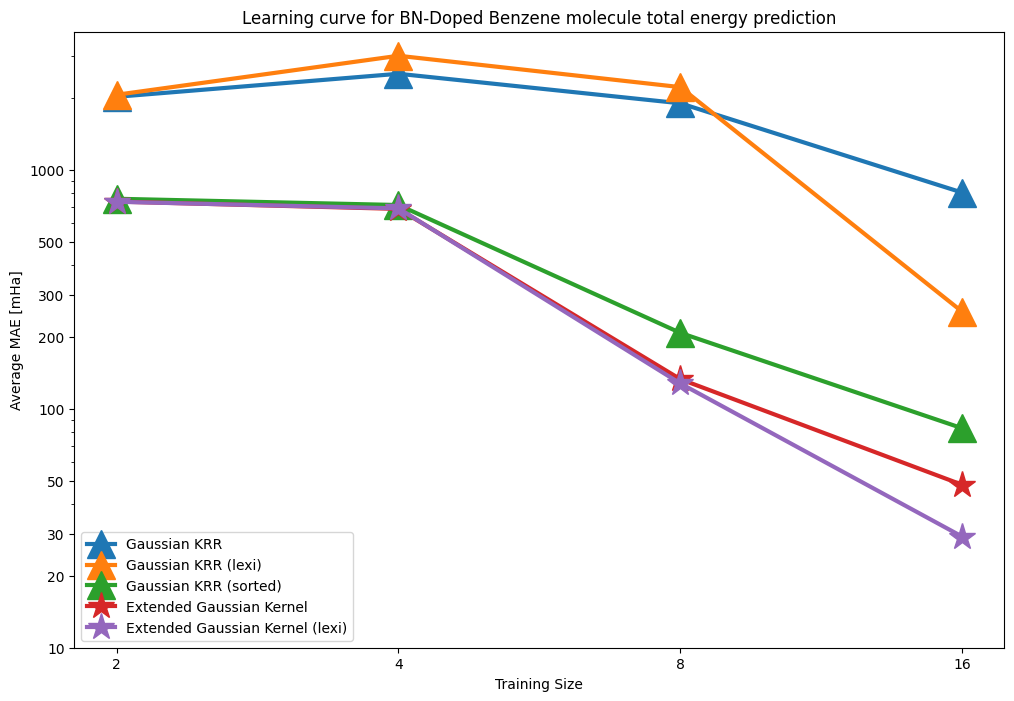

In [34]:
# Set figure size
plt.figure(figsize=(12, 8))

# Load the data
x = model_performance_gaussian['training size']

y1 = model_performance_gaussian['average MAE (mHa)']
y2 = model_performance_gaussian_lexi['average MAE (mHa)']
y3 = model_performance_gaussian_sorted['average MAE (mHa)']

y4 = model_performance_ex_gaussian['average MAE (mHa)']
y5 = model_performance_ex_gaussian_lexi['average MAE (mHa)']

# Plotting
linewidth = 3
markersize = 20

plt.plot(x, y1, label='Gaussian KRR', marker='^', linestyle='-', linewidth=linewidth, markersize=markersize)
plt.plot(x, y2, label='Gaussian KRR (lexi)', marker='^', linestyle='-', linewidth=linewidth, markersize=markersize)
plt.plot(x, y3, label='Gaussian KRR (sorted)', marker='^', linestyle='-', linewidth=linewidth, markersize=markersize)

plt.plot(x, y4, label='Extended Gaussian Kernel', marker='*', linestyle='-', linewidth=linewidth, markersize=markersize)
plt.plot(x, y5, label='Extended Gaussian Kernel (lexi)', marker='*', linestyle='-', linewidth=linewidth, markersize=markersize)


# Customize the plot
plt.title('Learning curve for BN-Doped Benzene molecule total energy prediction')
plt.xlabel('Training Size')
plt.ylabel('Average MAE [mHa]')
plt.legend()

# Create log scale
plt.xscale('log', base=2)
plt.yscale('log', base=10)

xticks = [2**i for i in range(1, 5)]
# yticks = [10**i for i in range(1, 4)]
yticks = [10, 20, 30, 50, 100, 200, 300, 500, 1000]
plt.xticks(xticks, labels = xticks)
plt.yticks(yticks, labels = yticks)


# Display the plot
plt.savefig('../Graph/[Benz] [3.0] [all] Learning curve for BN-Doped Benzene molecule total energy prediction.png', dpi=300)
plt.show()

### Comparing total vs electronic energy ###

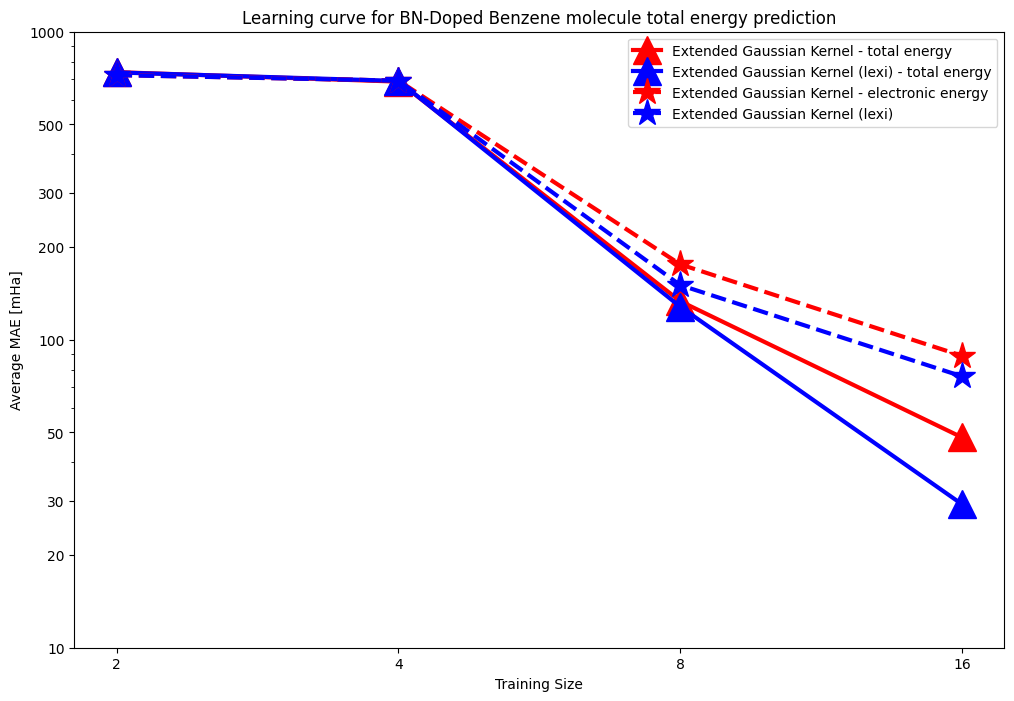

In [36]:
# Set figure size
plt.figure(figsize=(12, 8))

# Load the data
x = model_performance_gaussian['training size']

y4 = model_performance_ex_gaussian['average MAE (mHa)']
y5 = model_performance_ex_gaussian_lexi['average MAE (mHa)']
y6 = model_performance_ex_gaussian_elec['average MAE (mHa)']
y7 = model_performance_ex_gaussian_lexi_elec['average MAE (mHa)']

# Plotting
linewidth = 3
markersize = 20

plt.plot(x, y4, label='Extended Gaussian Kernel - total energy', marker='^', linestyle='-', linewidth=linewidth, markersize=markersize, color='red')
plt.plot(x, y5, label='Extended Gaussian Kernel (lexi) - total energy', marker='^', linestyle='-', linewidth=linewidth, markersize=markersize, color='b')
plt.plot(x, y6, label='Extended Gaussian Kernel - electronic energy', marker='*', linestyle='--', linewidth=linewidth, markersize=markersize, color='red')
plt.plot(x, y7, label='Extended Gaussian Kernel (lexi)', marker='*', linestyle='--', linewidth=linewidth, markersize=markersize, color='b')

# Customize the plot
plt.title('Learning curve for BN-Doped Benzene molecule total energy prediction')
plt.xlabel('Training Size')
plt.ylabel('Average MAE [mHa]')
plt.legend()

# Create log scale
plt.xscale('log', base=2)
plt.yscale('log', base=10)

xticks = [2**i for i in range(1, 5)]
# yticks = [10**i for i in range(1, 4)]
yticks = [10, 20, 30, 50, 100, 200, 300, 500, 1000]
plt.xticks(xticks, labels = xticks)
plt.yticks(yticks, labels = yticks)


# Display the plot
# plt.savefig('../Graph/[Benz] [3.0] [all] Learning curve for BN-Doped Benzene molecule total energy prediction.png', dpi=300)
plt.show()